In [132]:
# sqlite3 is built into Python - no need to install
print("sqlite3 is already available in Python")

sqlite3 is already available in Python


In [133]:
import sqlite3

In [134]:
connection=sqlite3.connect('chinook.db')

cursor=connection.cursor()

In [135]:
table_creation_query="""
CREATE TABLE IF NOT EXISTS employees (
    emp_id INTEGER PRIMARY KEY,
    first_name TEXT NOT NULL,
    last_name TEXT NOT NULL,
    email TEXT UNIQUE NOT NULL,
    hire_date TEXT NOT NULL,
    salary REAL NOT NULL
);
"""

In [136]:
table_creation_query2="""
CREATE TABLE IF NOT EXISTS customers (
    customer_id INTEGER PRIMARY KEY AUTOINCREMENT,
    first_name TEXT NOT NULL,
    last_name TEXT NOT NULL,
    email TEXT UNIQUE NOT NULL,
    phone TEXT
);
"""

In [137]:
table_creation_query3="""
CREATE TABLE IF NOT EXISTS orders (
    order_id INTEGER PRIMARY KEY AUTOINCREMENT,
    customer_id INTEGER NOT NULL,
    order_date TEXT NOT NULL,
    amount REAL NOT NULL,
    FOREIGN KEY (customer_id) REFERENCES customers (customer_id)
);

"""

In [138]:

cursor.execute(table_creation_query)
cursor.execute(table_creation_query2)
cursor.execute(table_creation_query3)

In [139]:
insert_query = """
INSERT INTO employees (emp_id, first_name, last_name, email, hire_date, salary)
VALUES (?, ?, ?, ?, ?, ?);
"""

In [140]:

insert_query_customers = """
INSERT INTO customers (customer_id, first_name, last_name, email, phone)
VALUES (?, ?, ?, ?, ?);
"""

In [141]:

insert_query_orders = """
INSERT INTO orders (order_id, customer_id, order_date, amount)
VALUES (?, ?, ?, ?);
"""

In [142]:
employee_data = [
    (1, "Sunny", "Savita", "sunny.sv@abc.com", "2023-06-01", 50000.00),
    (2, "Arhun", "Meheta", "arhun.m@gmail.com", "2022-04-15", 60000.00),
    (3, "Alice", "Johnson", "alice.johnson@jpg.com", "2021-09-30", 55000.00),
    (4, "Bob", "Brown", "bob.brown@uio.com", "2020-01-20", 45000.00),
    ]

In [143]:
customers_data = [
    (1, "John", "Doe", "john.doe@example.com", "1234567890"),
    (2, "Jane", "Smith", "jane.smith@example.com", "9876543210"),
    (3, "Emily", "Davis", "emily.davis@example.com", "4567891230"),
    (4, "Michael", "Brown", "michael.brown@example.com", "7894561230"),
]

In [144]:

orders_data = [
    (1, 1, "2023-12-01", 250.75),
    (2, 2, "2023-11-20", 150.50),
    (3, 3, "2023-11-25", 300.00),
    (4, 4, "2023-12-02", 450.00),
]

In [145]:
# Use INSERT OR IGNORE to avoid duplicate key errors
try:
    cursor.executemany(insert_query,employee_data)
    cursor.executemany(insert_query_customers,customers_data)
    cursor.executemany(insert_query_orders,orders_data)
    print("Data inserted successfully")
except Exception as e:
    print(f"Data may already exist: {e}")

Data may already exist: UNIQUE constraint failed: employees.emp_id


In [146]:
connection.commit()

In [147]:
cursor.execute("select * from employees;")

for row in cursor.fetchall():
    print(row)

(1, 'Sunny', 'Savita', 'sunny.sv@abc.com', '2023-06-01', 50000.0)
(2, 'Arhun', 'Meheta', 'arhun.m@gmail.com', '2022-04-15', 60000.0)
(3, 'Alice', 'Johnson', 'alice.johnson@jpg.com', '2021-09-30', 55000.0)
(4, 'Bob', 'Brown', 'bob.brown@uio.com', '2020-01-20', 45000.0)


In [148]:
cursor.fetchall()

[]

In [149]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_groq import ChatGroq
llm = ChatGroq(model="llama-3.1-8b-instant", temperature=0.0)

In [150]:
llm.invoke("Hello World")

AIMessage(content='Hello World. How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 37, 'total_tokens': 48, 'completion_time': 0.009723608, 'prompt_time': 0.034321406, 'queue_time': 0.047930384, 'total_time': 0.044045014}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_2115512ff6', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--5ce2e62a-f436-4679-9dce-830516bd195e-0', usage_metadata={'input_tokens': 37, 'output_tokens': 11, 'total_tokens': 48})

In [151]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///chinook.db")

In [152]:
print("Dialect",db.dialect)

Dialect sqlite


In [153]:
print(db.get_usable_table_names)

<bound method SQLDatabase.get_usable_table_names of <langchain_community.utilities.sql_database.SQLDatabase object at 0x00000229E2E41A60>>


In [154]:
query_res=db.run("select * from employees;")

print(query_res)

[(1, 'Sunny', 'Savita', 'sunny.sv@abc.com', '2023-06-01', 50000.0), (2, 'Arhun', 'Meheta', 'arhun.m@gmail.com', '2022-04-15', 60000.0), (3, 'Alice', 'Johnson', 'alice.johnson@jpg.com', '2021-09-30', 55000.0), (4, 'Bob', 'Brown', 'bob.brown@uio.com', '2020-01-20', 45000.0)]


In [155]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit


In [156]:
toolkit = SQLDatabaseToolkit(db=db, llm=llm)

In [157]:
tools=toolkit.get_tools()

In [158]:
for tool in tools :
    print(tool.name)

sql_db_query
sql_db_schema
sql_db_list_tables
sql_db_query_checker


In [159]:
list_tables_tool = next((tool for tool in tools if tool.name == "sql_db_list_tables"), None)

In [160]:
from langchain_core.tools import tool
@tool
def db_query_tool(query: str) -> str:
    """
    Execute a SQL query against the database and return the result.
    If the query is invalid or returns no result, an error message will be returned.
    In case of an error, the user is advised to rewrite the query and try again.
    """
    result = db.run_no_throw(query)
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    return result

In [161]:
from pydantic import BaseModel,Field
class SubmitFinalAnswer(BaseModel):
    """submit the final answer to the user based on the query results."""
    final_answer:str=Field(...,description="final answer to the query")


In [162]:
from langgraph.graph import MessagesState
from typing import Annotated ,TypedDict,Any
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
import operator

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [163]:

get_schema_tool = next((tool for tool in tools if tool.name == "sql_db_schema"), None)

In [164]:

from langchain_core.prompts import ChatPromptTemplate
query_check_system ="""You are a SQL expert with a strong attention to detail.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check."""
query_check_prompt=ChatPromptTemplate.from_messages(
    [
        ("system", query_check_system),
        ("placeholder", "{messages}"),
    ]
)

query_check = query_check_prompt | llm.bind_tools([db_query_tool])

query_check.invoke({"messages":[("user","select * from employees;")]})

AIMessage(content="The query appears to be correct. It is a simple SELECT statement that retrieves all columns from the 'employees' table. \n\n", additional_kwargs={'tool_calls': [{'id': '6e8kffjpj', 'function': {'arguments': '{"query":"select * from employees;"}', 'name': 'db_query_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 429, 'total_tokens': 472, 'completion_time': 0.065408752, 'prompt_time': 0.231647212, 'queue_time': 0.058529028, 'total_time': 0.297055964}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_7083106d2c', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b8ff0949-5946-450a-95e4-50ce9fbe7f01-0', tool_calls=[{'name': 'db_query_tool', 'args': {'query': 'select * from employees;'}, 'id': '6e8kffjpj', 'type': 'tool_call'}], usage_metadata={'input_tokens': 429, 'output_tokens': 43, 'total_tokens': 472})

In [165]:
query_gen_system = """You are a SQL expert with a strong attention to detail.

Given an input question, output a syntactically correct SQLite query to run, then look at the results of the query and return the answer.

DO NOT call any tool besides SubmitFinalAnswer to submit the final answer.

When generating the query:

Output the SQL query that answers the input question without a tool call.

Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.

If you get an error while executing a query, rewrite the query and try again.

If you get an empty result set, you should try to rewrite the query to get a non-empty result set.
NEVER make stuff up if you don't have enough information to answer the query... just say you don't have enough information.

If you have enough information to answer the input question, simply invoke the appropriate tool to submit the final answer to the user.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database. Do not return any sql query except answer."""


query_gen_prompt = ChatPromptTemplate.from_messages([("system", query_gen_system), ("placeholder", "{messages}")])

query_gen = query_gen_prompt | llm.bind_tools([
    SubmitFinalAnswer,
    get_schema_tool,
    db_query_tool
])

In [166]:
from typing import Annotated, Literal
from langchain_core.messages import AIMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from typing_extensions import TypedDict
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages
from typing import Any
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode

In [167]:
def first_tool_call(state:State)->dict[str,list[AIMessage]]:
    return{"messages": [AIMessage(content="",tool_calls=[{"name":"sql_db_list_tables","args":{},"id":"tool_abcd123"}])]}


In [168]:
def handle_tool_error(state:State) -> dict:
    error = state.get("error") 
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
        ToolMessage(content=f"Error: {repr(error)}\n please fix your mistakes.",tool_call_id=tc["id"],)
        for tc in tool_calls
        ]
    }
def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    return ToolNode(tools).with_fallbacks([RunnableLambda(handle_tool_error)], exception_key="error")

In [169]:
def query_gen_node(state: State):
    message = query_gen.invoke(state)

    # Sometimes, the LLM will hallucinate and call the wrong tool. We need to catch this and return an error message.
    tool_messages = []
    if message.tool_calls:
        for tc in message.tool_calls:
            if tc["name"] != "SubmitFinalAnswer":
                tool_messages.append(
                    ToolMessage(
                        content=f"Error: The wrong tool was called: {tc['name']}. Please fix your mistakes. Remember to only call SubmitFinalAnswer to submit the final answer. Generated queries should be outputted WITHOUT a tool call.",
                        tool_call_id=tc["id"],
                    )
                )
    else:
        tool_messages = []
    return {"messages": [message] + tool_messages}

In [170]:
def should_continue(state: State) -> Literal[END, "correct_query", "query_gen"]:
    messages = state["messages"]
    last_message = messages[-1]
    if getattr(last_message, "tool_calls", None):
        return END
    if last_message.content.startswith("Error:"):
        return "query_gen"
    else:
        return "correct_query"

In [171]:
def model_check_query(state: State) -> dict[str, list[AIMessage]]:
    """
    Use this tool to double-check if your query is correct before executing it.
    """
    return {"messages": [query_check.invoke({"messages": [state["messages"][-1]]})]}

In [172]:
workflow = StateGraph(State)

In [173]:
# Create a fresh workflow to avoid node duplication errors
workflow = StateGraph(State)

workflow.add_node("first_tool_call",first_tool_call)
workflow.add_node("list_tables_tool", create_tool_node_with_fallback([list_tables_tool]))
workflow.add_node("get_schema_tool", create_tool_node_with_fallback([get_schema_tool]))
model_get_schema = llm.bind_tools([get_schema_tool])
workflow.add_node("model_get_schema",lambda state: {"messages": [model_get_schema.invoke(state["messages"])],},)
workflow.add_node("query_gen", query_gen_node)
workflow.add_node("correct_query", model_check_query)
workflow.add_node("execute_query", create_tool_node_with_fallback([db_query_tool]))

In [174]:
workflow.add_edge(START, "first_tool_call")
workflow.add_edge("first_tool_call", "list_tables_tool")
workflow.add_edge("list_tables_tool", "model_get_schema")
workflow.add_edge("model_get_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "query_gen")
workflow.add_conditional_edges("query_gen",should_continue,)
workflow.add_edge("correct_query", "execute_query")
workflow.add_edge("execute_query", "query_gen")

In [175]:
app = workflow.compile()

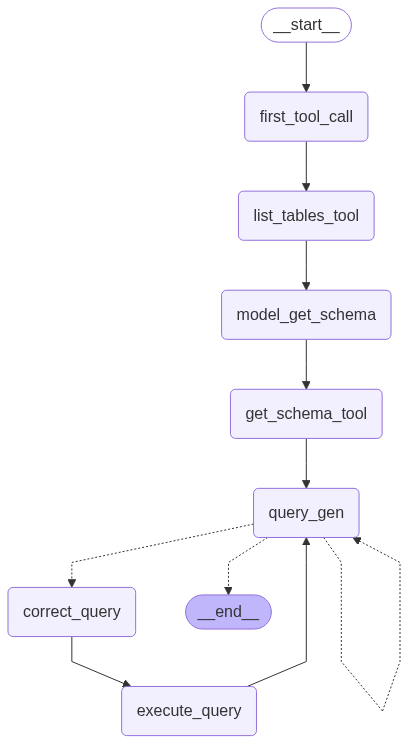

In [176]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
query={"messages": [("user", "Tell me name of the employee who's salary is more than 30000?")]}


{'messages': [HumanMessage(content="Tell me name of the employee who's salary is more than 30000?", additional_kwargs={}, response_metadata={}, id='02c1ea19-ca69-4467-8a47-4272aa565f62'),
  AIMessage(content='', additional_kwargs={}, response_metadata={}, id='fbf940df-4e7a-4f1d-b230-2383e0589822', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'tool_abcd123', 'type': 'tool_call'}]),
  ToolMessage(content='customers, employees, orders', name='sql_db_list_tables', id='706daea8-a6ce-4c56-be26-a888bb24cf13', tool_call_id='tool_abcd123'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '6k5263x3e', 'function': {'arguments': '{"table_names":"employees"}', 'name': 'sql_db_schema'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 376, 'total_tokens': 393, 'completion_time': 0.026232175, 'prompt_time': 0.20951431, 'queue_time': 0.05504649, 'total_time': 0.235746485}, 'model_name': 'llama-3.1-8b-instant', 'system_

In [179]:
response=app.invoke(query)

In [180]:
response["messages"][-1].tool_calls[0]["args"]["final_answer"]

"[('Bob', 'Brown'), ('Sunny', 'Savita'), ('Alice', 'Johnson'), ('Arhun', 'Meheta'), ('John', 'Doe')]"

In [181]:
query={"messages": [("user", "Tell me about all the orders")]}

In [183]:
response2 = app.invoke(query)

APIStatusError: Error code: 413 - {'error': {'message': 'Request too large for model `llama-3.1-8b-instant` in organization `org_01k4hfasgqey3b7fgmgcm98wag` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Requested 10130, please reduce your message size and try again. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

In [ ]:
response["messages"][-1].tool_calls[0]["args"]["final_answer"]